# Github Performance Metrics- Pull Requests

**Activity by Repo**

This notebook will aim to query the Augur DB to access the neccessary information to be able to get the following issue metrics dirived from the GitHub Community Metrics working document https://docs.google.com/document/d/1Yocr6fk0J8EsVZnJwoIl3kRQaI94tI-XHe7VSMFT0yM/edit?usp=sharing

Any necessary computations from the data to get the metric value will be done as the queries are determined

In [1]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import json
import os
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 5)
import warnings
warnings.filterwarnings('ignore')

with open("../../config_temp.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [3]:
#add your repo name(s) here of the repo(s) you want to query if known (and in the database)
repo_name_set = ['augur', 'grimoirelab']
repo_set = []

for repo_name in repo_name_set:
    repo_query = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                 SELECT 
                    b.repo_id
                FROM
                    repo_groups a,
                    repo b
                WHERE
                    a.repo_group_id = b.repo_group_id AND
                    b.repo_name = \'{repo_name}\'
        """)

    t = engine.execute(repo_query)
    repo_id =t.mappings().all()[0].get('repo_id')
    repo_set.append(repo_id)
print(repo_set)

[25440, 25448]


In [4]:
#Take this out of quotes if you want to manually assign a repo_id number(s)
#repo_set = [25440]

### Query for Pull Request Analysis

In [5]:
df_pr = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    r.repo_name,
					pr.pull_request_id AS pull_request, 
					pr.pr_created_at AS created, 
					pr.pr_closed_at AS closed,
					pr.pr_merged_at  AS merged 
                FROM
                	repo r,
                    pull_requests pr
                WHERE
                	r.repo_id = pr.repo_id AND
                    r.repo_id = \'{repo_id}\'
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_pr = pd.concat([df_pr, df_current_repo])

df_pr = df_pr.reset_index()
df_pr.drop("index", axis=1, inplace=True)
        
df_pr.head()

,repo_name,pull_request,created,closed,merged
0,augur,214028,2020-10-19 12:10:22,2020-10-19 13:27:26,NaT
1,augur,210011,2017-02-01 20:41:17,2017-02-02 16:51:16,2017-02-02 16:51:16
2,augur,210012,2017-02-01 21:43:24,2017-02-02 16:47:25,2017-02-02 16:47:25
3,augur,210019,2017-03-16 21:16:33,2017-03-16 21:17:07,2017-03-16 21:17:07
4,augur,210219,2019-10-23 22:27:53,2019-10-23 22:28:01,2019-10-23 22:28:01


In [6]:
df_pr_comments = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    r.repo_name,
                    prm.pull_request_id,
                    prm.pr_msg_ref_id,
                    pr.pr_created_at,
                    m.msg_timestamp msg_time,
					m.msg_text comment_text
                FROM
                	repo r,
                    pull_requests pr,
                    pull_request_message_ref prm, 
                    message m 
                WHERE
                	m.msg_id = prm.msg_id AND
                    prm.pull_request_id = pr.pull_request_id AND
                	pr.repo_id = r.repo_id AND
                    r.repo_id = \'{repo_id}\'
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_pr_comments = pd.concat([df_pr_comments, df_current_repo])

df_pr_comments = df_pr_comments.reset_index()
df_pr_comments.drop("index", axis=1, inplace=True)
        
df_pr_comments.head()

,repo_name,pull_request_id,pr_msg_ref_id,pr_created_at,msg_time,comment_text
0,augur,210007,498242,2017-01-23 18:50:08,2017-01-23 20:06:27,@germonprez What is wrong with the pip install...
1,augur,210007,498243,2017-01-23 18:50:08,2017-01-23 20:48:39,Nothing wrong with it. Happy to change. \r\n\r...
2,augur,210007,498244,2017-01-23 18:50:08,2017-01-23 20:49:48,@germonprez Sounds good!
3,augur,210009,498245,2017-02-01 20:33:36,2017-02-02 16:52:16,Thank you!
4,augur,210010,498246,2017-02-01 20:39:53,2017-02-02 16:50:14,@srobins259 I can't merge this into master bec...


In [7]:
#IF YOU ONLY WANT TO LOOK AT A ONE OF THE REPOS QUERIED 
repo_focus = 'augur'
df_pr_focus = df_pr[df_pr['repo_name'] == repo_focus]

## Median Time to Close/Merge

In [8]:
df_pr_closed = df_pr_focus[df_pr_focus['merged'].isnull()]
df_pr_merged = df_pr_focus[df_pr_focus['merged'].notna()]

df_pr_closed['time_to_close'] = (df_pr_closed.closed - df_pr_closed.created)
df_pr_merged['time_to_merge'] = (df_pr_merged.merged - df_pr_merged.created)

In [9]:
df_pr_closed_monthly = df_pr_closed['time_to_close'].groupby(df_pr_closed.created.dt.to_period("M")).agg('median')
df_pr_merged_monthly = df_pr_merged['time_to_merge'].groupby(df_pr_merged.created.dt.to_period("M")).agg('median')
df_pr_closed_monthly = df_pr_closed_monthly.astype('timedelta64[D]')
df_pr_merged_monthly = df_pr_merged_monthly.astype('timedelta64[D]')

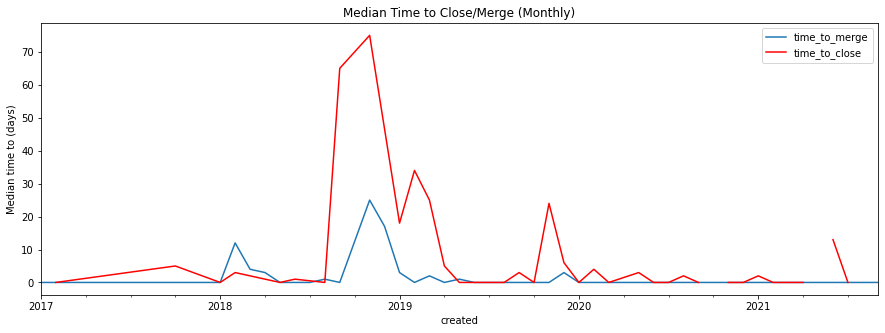

In [10]:
ax = plt.gca()

plt.xlabel("Month")
plt.ylabel("Median time to (days)")
plt.title("Median Time to Close/Merge (Monthly)")

df_pr_merged_monthly.plot(kind='line',x='created',y='time_to_merge',ax=ax,legend = True)
df_pr_closed_monthly.plot(kind='line',x='created',y='time_to_close', color='red', ax=ax,legend = True)
plt.show()

## Monthly PRs Close/Merged

In [11]:
df_pr_c_m_monthly = df_pr_focus[['merged','closed']].groupby(df_pr.closed.dt.to_period("M")).agg('count')

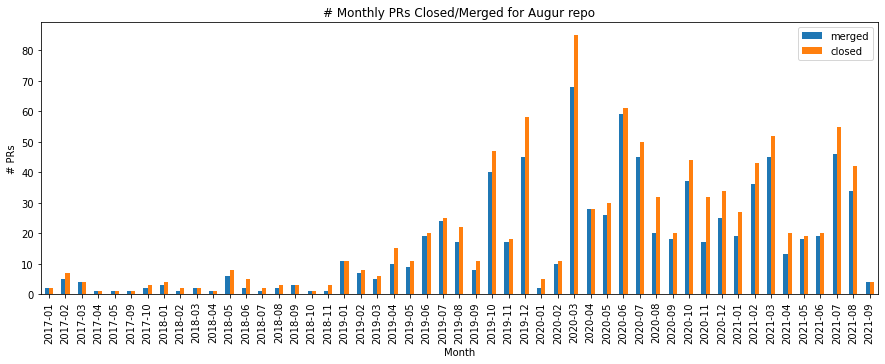

In [12]:
df_pr_c_m_monthly.plot.bar()

plt.xlabel("Month")
plt.ylabel("# PRs")
plt.title("# Monthly PRs Closed/Merged for "+repo_focus.capitalize() +" repo")
plt.show()

## Percent Pull Requests merged vs not 

In [13]:
df_pr_compare = df_pr_focus.dropna(subset=['closed'])
df_pr_compare["merged_in"] = False
df_pr_compare["merged_in"] = df_pr_compare["merged_in"].where(df_pr_compare["merged"].isna(),other= True)

In [14]:
percent = df_pr_compare["pull_request"].groupby(df_pr_compare.merged_in).agg('count')

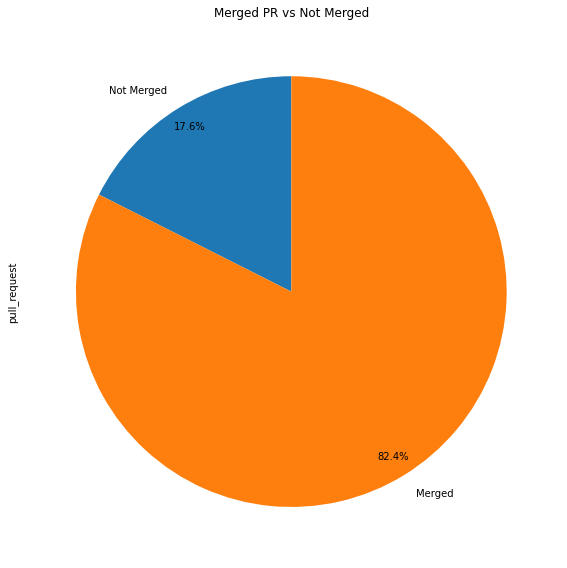

In [15]:
labels = ["Not Merged","Merged"]
percent.plot.pie(figsize=(15,8),autopct='%1.1f%%',startangle=90,pctdistance=0.9,labels=labels)
plt.title("Merged PR vs Not Merged")
plt.tight_layout()
plt.show()

## Time to First Response PR

In [16]:
df_pr_comments_focus = df_pr_comments[df_pr_comments['repo_name'] == repo_focus]
df_pr_comments_focus = df_pr_comments_focus.sort_values(by= "msg_time")
df_pr_comments_focus = df_pr_comments_focus.reset_index(drop=True)
df_pr_comments_focus = df_pr_comments_focus.drop_duplicates(subset='pull_request_id', keep='first')

In [17]:
not_answered = df_pr_focus.shape[0]-df_pr_comments_focus.shape[0]
answered = df_pr_comments_focus.shape[0]

### Pie Chart- Reponse Percent

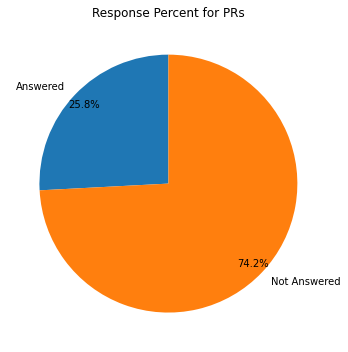

In [18]:
labels = ["Answered","Not Answered"]
sizes = [answered,not_answered]
plt.pie(sizes,autopct='%1.1f%%',startangle=90,pctdistance=0.9,labels=labels)
plt.title("Response Percent for PRs")
plt.tight_layout()
plt.show()

In [19]:
df_pr_comments_focus['time_to_response'] = (df_pr_comments_focus.msg_time - df_pr_comments_focus.pr_created_at)
df_pr_comments_focus = df_pr_comments_focus[df_pr_comments_focus['time_to_response'] >= pd.Timedelta(0)]

In [20]:
df_pr_comments_monthly = df_pr_comments_focus['time_to_response'].groupby(df_pr_comments_focus.pr_created_at.dt.to_period("M")).agg('mean')
df_pr_comments_monthly = df_pr_comments_monthly.astype('timedelta64[D]')

### Bar Chart: Median time of First Reponse

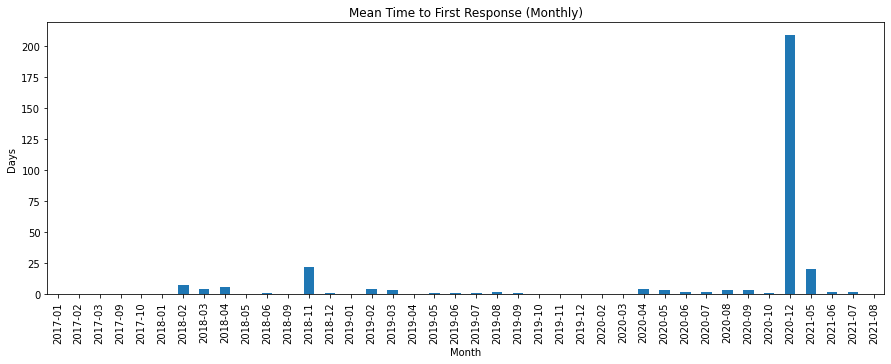

In [21]:
df_pr_comments_monthly.plot.bar()
plt.xlabel("Month")
plt.ylabel("Days")
plt.title("Mean Time to First Response (Monthly)")
plt.show()

In [22]:
df_pr_comments_focus.describe()

,pull_request_id,pr_msg_ref_id,time_to_response
count,271.000000,271.000000,271
mean,211736.428044,500125.011070,2 days 13:02:08.948339483
std,2723.651467,2603.736202,13 days 08:51:00.163894737
min,210007.000000,498242.000000,0 days 00:00:01
25%,210133.000000,498380.500000,0 days 00:00:39
50%,210292.000000,498509.000000,0 days 01:39:17
75%,213622.500000,503704.500000,1 days 17:02:23.500000
max,219695.000000,504676.000000,209 days 08:17:21
